## NN Adv Assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings(action='ignore')

### Load Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [4]:
train['label'].nunique()

10

In [5]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,67,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,2,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,93,58,78,45,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,71,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,63,0,0,0,0,0,0,0


In [6]:
X = train.iloc[:, :-1].values
y = train.iloc[:, -1].values

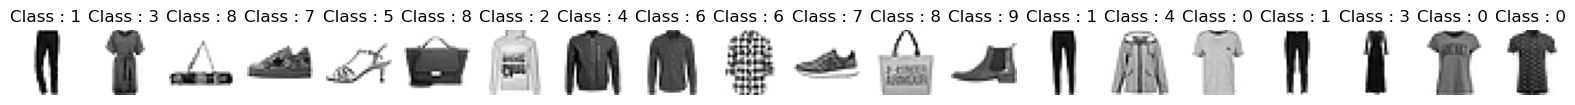

In [7]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X[idx].reshape(28, 28), cmap='gray_r')
  plt.title(f'Class : {y[idx]}')

In [8]:
X_test = test.values

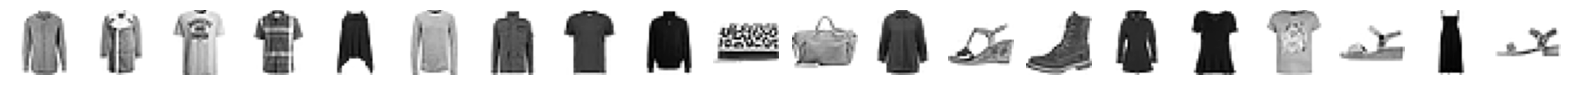

In [9]:
pltsize = 1
plt.figure(figsize=(20 * pltsize, pltsize))
for idx in range(0, 20):
  plt.subplot(1, 20, idx + 1)
  plt.axis('off')
  plt.imshow(X_test[idx].reshape(28, 28), cmap='gray_r')

### Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.FloatTensor(X_test)

In [11]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print(DEVICE)

cpu


In [12]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

def train(model, train_loader):
  model.train()
  train_loss = 0
  correct = 0

  for image, label in train_loader:
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    prediction = output.max(1, keepdim = True)[1]
    correct += prediction.eq(label.view_as(prediction)).sum().item()
      
  train_loss /= len(train_loader)
  train_accuracy = 100. * correct / len(train_loader.dataset)
  return train_loss, train_accuracy

def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

In [13]:
BATCH_SIZE = 128
EPOCHS = 100

train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

### BaseLine Model

In [14]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 18)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [15]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.6447, 	Train Accuracy: 77.04 %, 	Val Loss: 0.6166, 	Val Accuracy: 75.90 % 

[EPOCH: 2], 	Train Loss: 0.6080, 	Train Accuracy: 78.51 %, 	Val Loss: 0.5943, 	Val Accuracy: 78.66 % 

[EPOCH: 3], 	Train Loss: 0.6044, 	Train Accuracy: 78.72 %, 	Val Loss: 0.6385, 	Val Accuracy: 77.51 % 

[EPOCH: 4], 	Train Loss: 0.5923, 	Train Accuracy: 79.07 %, 	Val Loss: 0.6617, 	Val Accuracy: 77.19 % 

[EPOCH: 5], 	Train Loss: 0.5925, 	Train Accuracy: 79.14 %, 	Val Loss: 0.5845, 	Val Accuracy: 78.93 % 

[EPOCH: 6], 	Train Loss: 0.5933, 	Train Accuracy: 79.04 %, 	Val Loss: 0.6049, 	Val Accuracy: 77.10 % 

[EPOCH: 7], 	Train Loss: 0.5892, 	Train Accuracy: 79.25 %, 	Val Loss: 0.5496, 	Val Accuracy: 78.60 % 

[EPOCH: 8], 	Train Loss: 0.5845, 	Train Accuracy: 79.45 %, 	Val Loss: 0.5541, 	Val Accuracy: 80.28 % 

[EPOCH: 9], 	Train Loss: 0.5913, 	Train Accuracy: 79.18 %, 	Val Loss: 0.5442, 	Val Accuracy: 80.97 % 

[EPOCH: 10], 	Train Loss: 0.5915, 	Train Accuracy: 79.21 %, 	Val Loss: 0.

[EPOCH: 80], 	Train Loss: 0.5803, 	Train Accuracy: 79.68 %, 	Val Loss: 0.5501, 	Val Accuracy: 81.27 % 

[EPOCH: 81], 	Train Loss: 0.5814, 	Train Accuracy: 79.77 %, 	Val Loss: 0.6309, 	Val Accuracy: 78.40 % 

[EPOCH: 82], 	Train Loss: 0.5786, 	Train Accuracy: 79.55 %, 	Val Loss: 0.5558, 	Val Accuracy: 80.39 % 

[EPOCH: 83], 	Train Loss: 0.5752, 	Train Accuracy: 79.85 %, 	Val Loss: 0.5343, 	Val Accuracy: 81.39 % 

[EPOCH: 84], 	Train Loss: 0.5820, 	Train Accuracy: 79.73 %, 	Val Loss: 0.5091, 	Val Accuracy: 82.31 % 

[EPOCH: 85], 	Train Loss: 0.5826, 	Train Accuracy: 79.55 %, 	Val Loss: 0.5472, 	Val Accuracy: 79.58 % 

[EPOCH: 86], 	Train Loss: 0.5813, 	Train Accuracy: 79.60 %, 	Val Loss: 0.5155, 	Val Accuracy: 81.90 % 

[EPOCH: 87], 	Train Loss: 0.5853, 	Train Accuracy: 79.78 %, 	Val Loss: 0.5206, 	Val Accuracy: 81.03 % 

[EPOCH: 88], 	Train Loss: 0.5831, 	Train Accuracy: 79.67 %, 	Val Loss: 0.5222, 	Val Accuracy: 81.57 % 

[EPOCH: 89], 	Train Loss: 0.5813, 	Train Accuracy: 79.58 %, 	Val

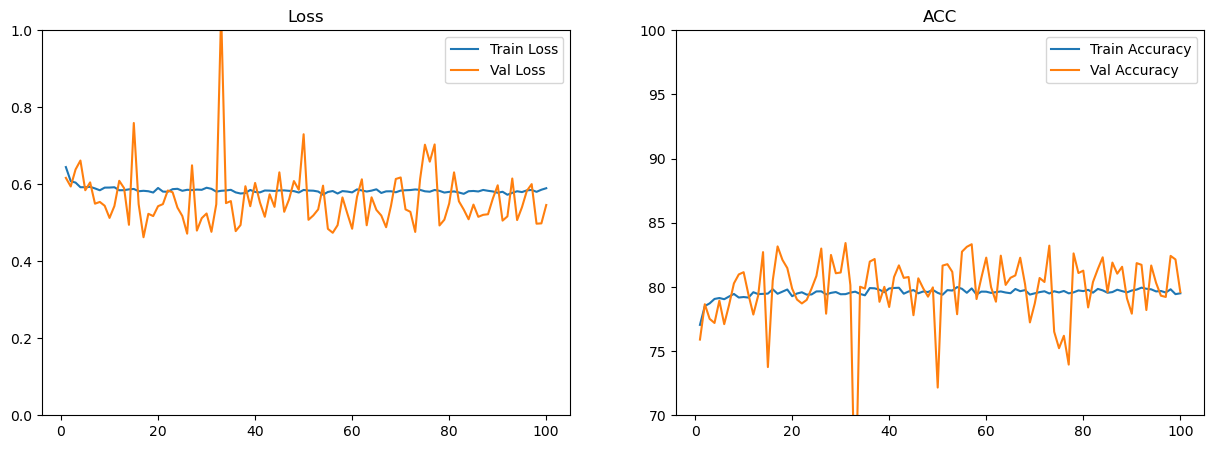

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(70, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [21]:
acc = 0
for dct in result_list:
    if dct["Val Accuracy"] > acc:
        acc = dct["Val Accuracy"]
print(acc)

83.4201680672269


### Customed Model

In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.BatchNorm1d(512),
        nn.ELU(),
        nn.Dropout(0.2)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ELU(),
        nn.Dropout(0.2)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ELU(),
        nn.Dropout(0.2)
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ELU(),
        nn.Dropout(0.2)
    )
    self.linear5 = nn.Sequential(
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ELU(),
        nn.Dropout(0.2)
    )
    self.linear6 = nn.Sequential(
        nn.Linear(32, 18)
    )

    self._init_weight_()

  def _init_weight_(self):
    for m in self.linear1:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear2:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

    for m in self.linear3:
      if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.linear5(x)
    x = self.linear6(x)
    return x

In [27]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

In [28]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.7397, 	Train Accuracy: 74.50 %, 	Val Loss: 0.5613, 	Val Accuracy: 80.25 % 

[EPOCH: 2], 	Train Loss: 0.6517, 	Train Accuracy: 77.26 %, 	Val Loss: 0.5359, 	Val Accuracy: 80.66 % 

[EPOCH: 3], 	Train Loss: 0.6466, 	Train Accuracy: 77.47 %, 	Val Loss: 0.6074, 	Val Accuracy: 79.30 % 

[EPOCH: 4], 	Train Loss: 0.6313, 	Train Accuracy: 78.16 %, 	Val Loss: 0.6865, 	Val Accuracy: 76.53 % 

[EPOCH: 5], 	Train Loss: 0.6272, 	Train Accuracy: 78.20 %, 	Val Loss: 0.5214, 	Val Accuracy: 81.53 % 

[EPOCH: 6], 	Train Loss: 0.6272, 	Train Accuracy: 78.30 %, 	Val Loss: 0.7345, 	Val Accuracy: 73.20 % 

[EPOCH: 7], 	Train Loss: 0.6279, 	Train Accuracy: 78.23 %, 	Val Loss: 0.5627, 	Val Accuracy: 78.89 % 

[EPOCH: 8], 	Train Loss: 0.6223, 	Train Accuracy: 78.50 %, 	Val Loss: 0.6283, 	Val Accuracy: 78.10 % 

[EPOCH: 9], 	Train Loss: 0.6271, 	Train Accuracy: 78.30 %, 	Val Loss: 0.5779, 	Val Accuracy: 79.85 % 

[EPOCH: 10], 	Train Loss: 0.6230, 	Train Accuracy: 78.51 %, 	Val Loss: 0.

[EPOCH: 80], 	Train Loss: 0.6128, 	Train Accuracy: 78.98 %, 	Val Loss: 0.5284, 	Val Accuracy: 81.40 % 

[EPOCH: 81], 	Train Loss: 0.6144, 	Train Accuracy: 78.94 %, 	Val Loss: 0.5477, 	Val Accuracy: 81.09 % 

[EPOCH: 82], 	Train Loss: 0.6139, 	Train Accuracy: 78.95 %, 	Val Loss: 0.5418, 	Val Accuracy: 80.94 % 

[EPOCH: 83], 	Train Loss: 0.6145, 	Train Accuracy: 78.94 %, 	Val Loss: 0.5939, 	Val Accuracy: 78.10 % 

[EPOCH: 84], 	Train Loss: 0.6117, 	Train Accuracy: 78.99 %, 	Val Loss: 0.5050, 	Val Accuracy: 82.03 % 

[EPOCH: 85], 	Train Loss: 0.6112, 	Train Accuracy: 78.77 %, 	Val Loss: 0.5132, 	Val Accuracy: 81.23 % 

[EPOCH: 86], 	Train Loss: 0.6108, 	Train Accuracy: 79.09 %, 	Val Loss: 0.5758, 	Val Accuracy: 79.31 % 

[EPOCH: 87], 	Train Loss: 0.6197, 	Train Accuracy: 78.61 %, 	Val Loss: 0.5535, 	Val Accuracy: 80.86 % 

[EPOCH: 88], 	Train Loss: 0.6099, 	Train Accuracy: 78.84 %, 	Val Loss: 0.5656, 	Val Accuracy: 79.45 % 

[EPOCH: 89], 	Train Loss: 0.6117, 	Train Accuracy: 78.94 %, 	Val

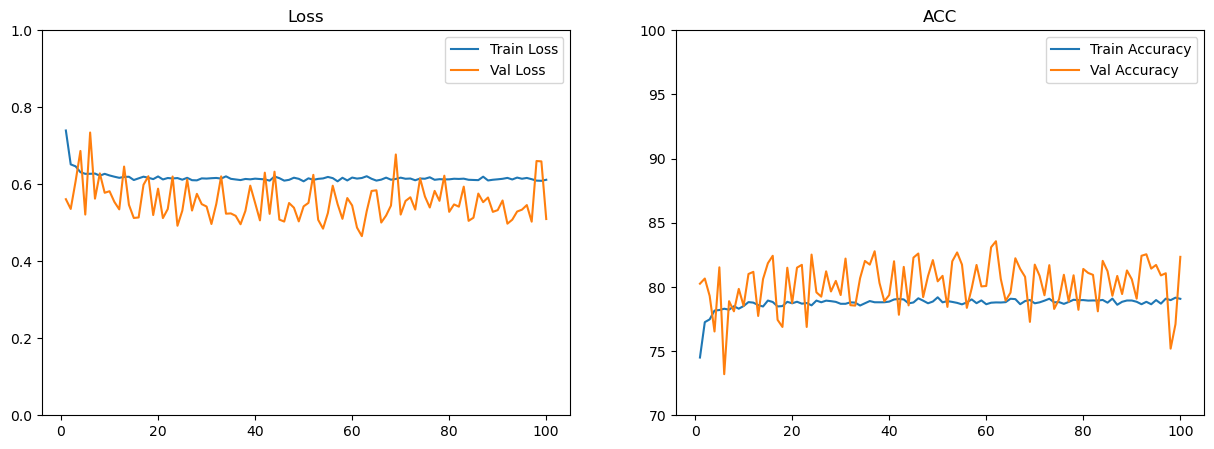

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(70, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [30]:
acc = 0
for dct in result_list:
    if dct["Val Accuracy"] > acc:
        acc = dct["Val Accuracy"]
print(acc)

83.56302521008404


#### reduce LR
- Loss가 진동하기 때문(감소하는 추세가 거의 보이지 않음)

In [32]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss()

In [33]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 0.8162, 	Train Accuracy: 78.43 %, 	Val Loss: 0.6337, 	Val Accuracy: 76.49 % 

[EPOCH: 2], 	Train Loss: 0.5211, 	Train Accuracy: 82.42 %, 	Val Loss: 0.4215, 	Val Accuracy: 85.08 % 

[EPOCH: 3], 	Train Loss: 0.4893, 	Train Accuracy: 83.10 %, 	Val Loss: 0.5006, 	Val Accuracy: 81.05 % 

[EPOCH: 4], 	Train Loss: 0.4853, 	Train Accuracy: 83.00 %, 	Val Loss: 0.4173, 	Val Accuracy: 84.91 % 

[EPOCH: 5], 	Train Loss: 0.4786, 	Train Accuracy: 83.31 %, 	Val Loss: 0.4417, 	Val Accuracy: 83.95 % 

[EPOCH: 6], 	Train Loss: 0.4777, 	Train Accuracy: 83.34 %, 	Val Loss: 0.4138, 	Val Accuracy: 85.26 % 

[EPOCH: 7], 	Train Loss: 0.4689, 	Train Accuracy: 83.52 %, 	Val Loss: 0.4427, 	Val Accuracy: 84.56 % 

[EPOCH: 8], 	Train Loss: 0.4710, 	Train Accuracy: 83.57 %, 	Val Loss: 0.4482, 	Val Accuracy: 84.13 % 

[EPOCH: 9], 	Train Loss: 0.4662, 	Train Accuracy: 83.54 %, 	Val Loss: 0.3997, 	Val Accuracy: 85.41 % 

[EPOCH: 10], 	Train Loss: 0.4577, 	Train Accuracy: 83.84 %, 	Val Loss: 0.

[EPOCH: 80], 	Train Loss: 0.4205, 	Train Accuracy: 85.34 %, 	Val Loss: 0.4332, 	Val Accuracy: 83.71 % 

[EPOCH: 81], 	Train Loss: 0.4170, 	Train Accuracy: 85.43 %, 	Val Loss: 0.3659, 	Val Accuracy: 86.85 % 

[EPOCH: 82], 	Train Loss: 0.4177, 	Train Accuracy: 85.41 %, 	Val Loss: 0.3737, 	Val Accuracy: 86.83 % 

[EPOCH: 83], 	Train Loss: 0.4145, 	Train Accuracy: 85.61 %, 	Val Loss: 0.4149, 	Val Accuracy: 85.66 % 

[EPOCH: 84], 	Train Loss: 0.4154, 	Train Accuracy: 85.66 %, 	Val Loss: 0.3792, 	Val Accuracy: 86.46 % 

[EPOCH: 85], 	Train Loss: 0.4150, 	Train Accuracy: 85.56 %, 	Val Loss: 0.3785, 	Val Accuracy: 86.64 % 

[EPOCH: 86], 	Train Loss: 0.4140, 	Train Accuracy: 85.66 %, 	Val Loss: 0.3725, 	Val Accuracy: 86.71 % 

[EPOCH: 87], 	Train Loss: 0.4178, 	Train Accuracy: 85.41 %, 	Val Loss: 0.3619, 	Val Accuracy: 87.09 % 

[EPOCH: 88], 	Train Loss: 0.4175, 	Train Accuracy: 85.43 %, 	Val Loss: 0.3813, 	Val Accuracy: 86.26 % 

[EPOCH: 89], 	Train Loss: 0.4151, 	Train Accuracy: 85.55 %, 	Val

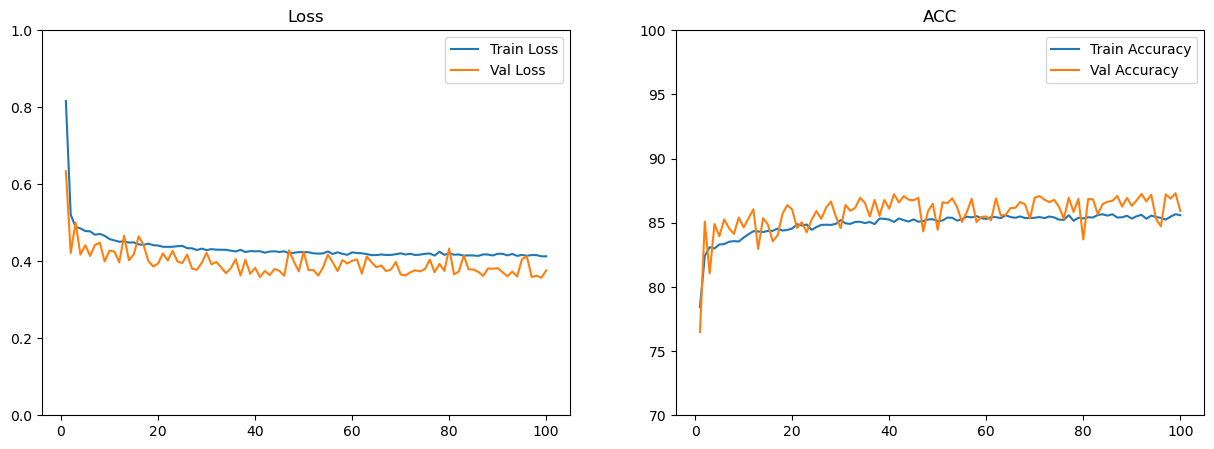

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].plot(result_df['EPOCH'], result_df['Train Loss'], label='Train Loss')
axes[0].plot(result_df['EPOCH'], result_df['Val Loss'], label='Val Loss')
axes[0].set_ylim(0.0, 1)
axes[0].legend()
axes[0].set_title('Loss')

axes[1].plot(result_df['EPOCH'], result_df['Train Accuracy'], label='Train Accuracy')
axes[1].plot(result_df['EPOCH'], result_df['Val Accuracy'], label='Val Accuracy')
axes[1].set_ylim(70, 100)
axes[1].legend()
axes[1].set_title('ACC')

plt.show()

In [35]:
acc = 0
for dct in result_list:
    if dct["Val Accuracy"] > acc:
        acc = dct["Val Accuracy"]
print(acc)

87.30252100840336
